In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
X_combined = pd.read_csv('data/engineered_features.csv')
df = pd.read_csv('data/data_cleaned.csv')

## Training and models

In [21]:
X = X_combined
y = df['is_helpful']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    model.fit(X_train, y_train)  # X_train can be your TF-IDF or other features
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred))

print(f"\n=== Summary ===")
for name, acc in results.items():
    print(f"{name}: {acc:.3f}")



=== Training Logistic Regression ===
Accuracy: 0.675
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1376
           1       0.66      0.68      0.67      1320

    accuracy                           0.68      2696
   macro avg       0.68      0.68      0.68      2696
weighted avg       0.68      0.68      0.68      2696


=== Training Random Forest ===
Accuracy: 0.718
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1376
           1       0.71      0.72      0.71      1320

    accuracy                           0.72      2696
   macro avg       0.72      0.72      0.72      2696
weighted avg       0.72      0.72      0.72      2696


=== Training XGBoost ===
Accuracy: 0.696
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1376
           1       0.69      0.70      0.69      1320

    accuracy                          


=== Training Logistic Regression ===
Best params: {'C': 0.1}
Metrics: {'accuracy': 0.6910237388724035, 'precision': 0.6834966088922382, 'recall': 0.6871212121212121, 'f1': 0.685304117869286}

=== Training Random Forest ===
Best params: {'max_depth': None, 'n_estimators': 200}
Metrics: {'accuracy': 0.7166172106824926, 'precision': 0.7026239067055393, 'recall': 0.7303030303030303, 'f1': 0.7161961367013373}

=== Training XGBoost ===
Best params: {'max_depth': 3, 'n_estimators': 100}
Metrics: {'accuracy': 0.712166172106825, 'precision': 0.6971014492753623, 'recall': 0.7287878787878788, 'f1': 0.7125925925925926}

=== Training CatBoost ===
Best params: {'depth': 5, 'iterations': 200}
Metrics: {'accuracy': 0.7032640949554896, 'precision': 0.6881331403762663, 'recall': 0.7204545454545455, 'f1': 0.7039230199851961}


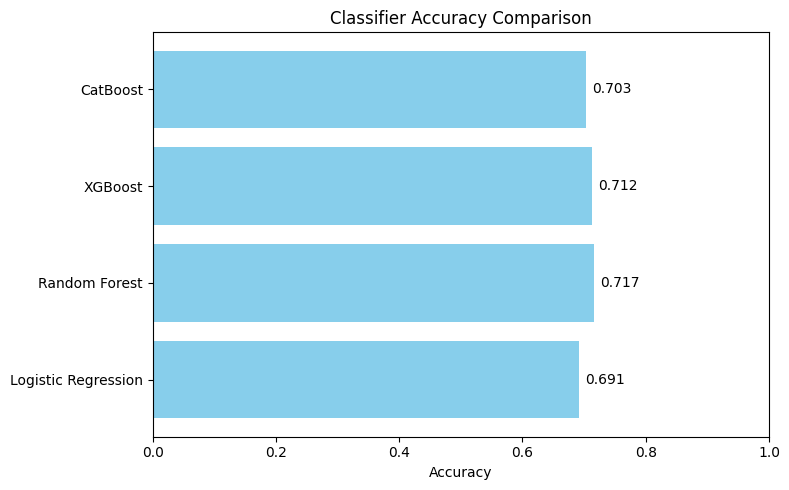

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), 
                            {'C': [0.1, 1, 10]}),
    'Random Forest': (RandomForestClassifier(random_state=42), 
                      {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                {'n_estimators': [100, 200], 'max_depth': [3, 5]}),
    'CatBoost': (CatBoostClassifier(verbose=0, random_state=42),
                 {'iterations': [100, 200], 'depth': [3, 5]})
}

results = {}
for name, (model, params) in models.items():
    print(f"\n=== Training {name} ===")
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
    # Scale only for models that require it
    if name in ['Logistic Regression', 'SVC']:
        grid.fit(X_train_scaled, y_train)
        y_pred = grid.predict(X_test_scaled)
    else:
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    results[name] = metrics
    
    print(f"Best params: {grid.best_params_}")
    print(f"Metrics: {metrics}")

accuracy_df = pd.DataFrame({name: metrics['accuracy'] for name, metrics in results.items()}, index=['Accuracy']).T

plt.figure(figsize=(8,5))
plt.barh(accuracy_df.index, accuracy_df['Accuracy'], color='skyblue')
plt.xlim(0, 1)
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
for i, v in enumerate(accuracy_df['Accuracy']):
    plt.text(v + 0.01, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()

## Feature Importance

In [5]:
# best model
rf_original = RandomForestClassifier(random_state=42, n_estimators=100)
rf_original.fit(X_train, y_train)

engineered_features = ['word_count', 'char_count', 'sentence_count', 'avg_sentence_length',
                      'exclamation_count', 'question_count', 'capital_count', 'capital_ratio',
                      'polarity', 'subjectivity', 'flesch_reading_ease', 'flesch_kincaid_grade',
                      'vague_word_count', 'vague_ratio', 'month', 'is_weekend']
plt.style.use('default')

# feature importance
feature_importance = pd.DataFrame({
    'feature': X_combined.columns,
    'importance': rf_original.feature_importances_
}).sort_values('importance', ascending=False)

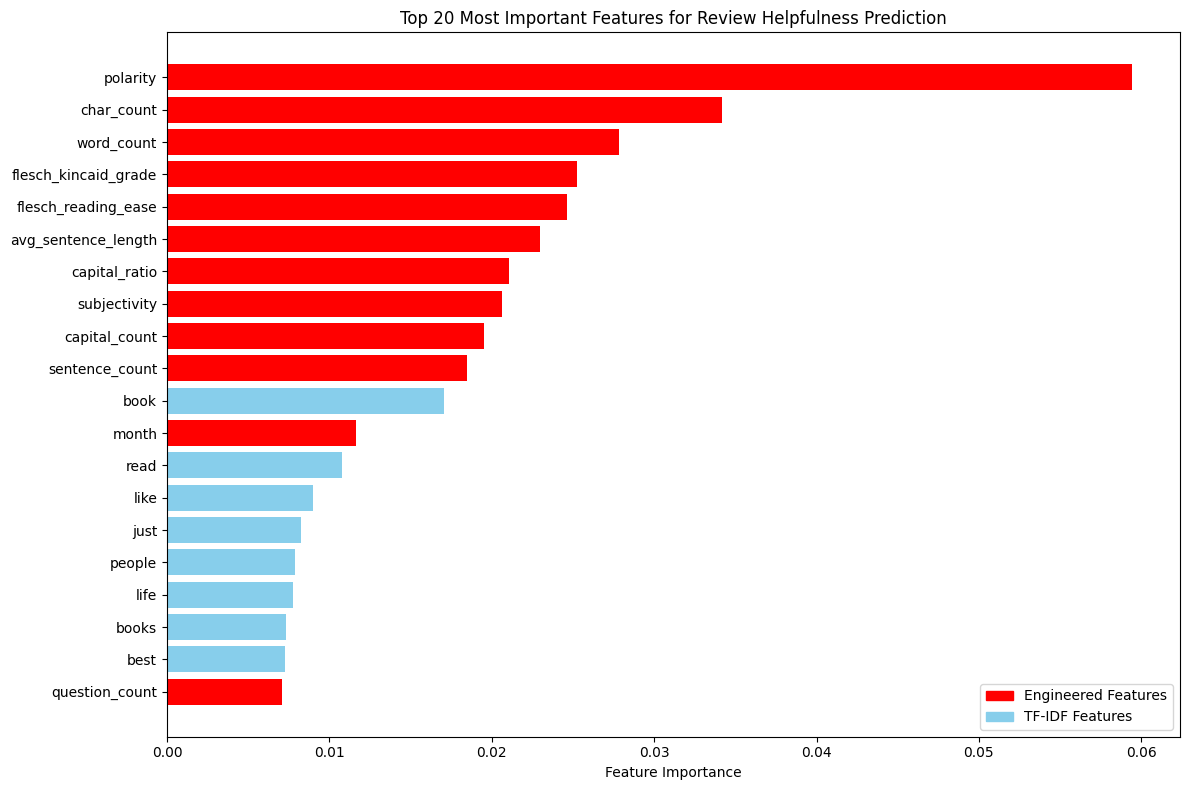

In [6]:
# Top 20 Features Bar Plot
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
colors = ['red' if feat in engineered_features else 'skyblue' for feat in top_20['feature']]

plt.barh(range(len(top_20)), top_20['importance'], color=colors)
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features for Review Helpfulness Prediction')
plt.gca().invert_yaxis()

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Engineered Features')
blue_patch = mpatches.Patch(color='skyblue', label='TF-IDF Features')
plt.legend(handles=[red_patch, blue_patch])
plt.tight_layout()
plt.show()

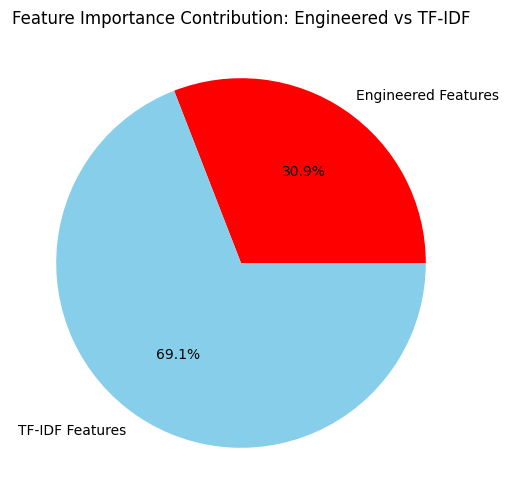

In [7]:
# Engineered Features vs TF-IDF Contribution in terms of feature importance
engineered_importance = feature_importance[feature_importance['feature'].isin(engineered_features)]
tfidf_importance = feature_importance[~feature_importance['feature'].isin(engineered_features)]

contribution_data = {
    'Feature Type': ['Engineered Features', 'TF-IDF Features'],
    'Total Importance': [engineered_importance['importance'].sum(), 
                        tfidf_importance['importance'].sum()]
}

plt.figure(figsize=(8, 6))
plt.pie(contribution_data['Total Importance'], 
        labels=contribution_data['Feature Type'], 
        autopct='%1.1f%%',
        colors=['red', 'skyblue'])
plt.title('Feature Importance Contribution: Engineered vs TF-IDF')
plt.show()

In [8]:
# Get the engineered features from X_combined
engineered_features = ['word_count', 'char_count', 'sentence_count', 'avg_sentence_length',
                      'exclamation_count', 'question_count', 'capital_count', 'capital_ratio',
                      'polarity', 'subjectivity', 'flesch_reading_ease', 'flesch_kincaid_grade',
                      'vague_word_count', 'vague_ratio', 'month', 'is_weekend']

available_features = [f for f in engineered_features if f in X_combined.columns]
analysis_df = pd.DataFrame(X_combined[available_features])
analysis_df['is_helpful'] = df['is_helpful']

In [9]:
# Calculate differences for ALL available features
feature_differences = []

for feature in available_features:
    helpful_mean = analysis_df[analysis_df['is_helpful']==1][feature].mean()
    not_helpful_mean = analysis_df[analysis_df['is_helpful']==0][feature].mean()
    abs_diff = abs(helpful_mean - not_helpful_mean)
    if not_helpful_mean != 0:
        pct_diff = abs(helpful_mean - not_helpful_mean) / abs(not_helpful_mean) * 100
    else:
        pct_diff = float('inf') if helpful_mean != 0 else 0
    
    feature_differences.append({
        'feature': feature,
        'helpful_mean': helpful_mean,
        'not_helpful_mean': not_helpful_mean,
        'raw_difference': helpful_mean - not_helpful_mean,
        'abs_difference': abs_diff,
        'percent_difference': pct_diff
    })

diff_df = pd.DataFrame(feature_differences)
diff_df = diff_df.sort_values('percent_difference', ascending=False)

# top features
print("=== 10 Most Discriminating Features ===")
print("(Features that show the biggest relative differences between helpful/unhelpful reviews)")
print("\nFeature | Helpful | Not Helpful | Raw Diff | % Diff")
print("-" * 70)

for idx, row in diff_df.head(10).iterrows():
    print(f"{row['feature']:<20} | {row['helpful_mean']:>7.3f} | {row['not_helpful_mean']:>11.3f} | {row['raw_difference']:>8.3f} | {row['percent_difference']:>6.1f}%")

# bottom features
print(f"\n=== Least Discriminating Features ===")
print("(Features that are similar between helpful/unhelpful reviews)")
print("\nFeature | Helpful | Not Helpful | Raw Diff | % Diff")
print("-" * 70)

for idx, row in diff_df.tail(5).iterrows():
    print(f"{row['feature']:<20} | {row['helpful_mean']:>7.3f} | {row['not_helpful_mean']:>11.3f} | {row['raw_difference']:>8.3f} | {row['percent_difference']:>6.1f}%")

=== 10 Most Discriminating Features ===
(Features that show the biggest relative differences between helpful/unhelpful reviews)

Feature | Helpful | Not Helpful | Raw Diff | % Diff
----------------------------------------------------------------------
polarity             |   0.183 |       0.116 |    0.068 |   58.4%
char_count           | 1374.582 |    1039.037 |  335.545 |   32.3%
word_count           | 270.755 |     207.483 |   63.272 |   30.5%
question_count       |   0.369 |       0.524 |   -0.155 |   29.6%
vague_ratio          |   0.001 |       0.002 |   -0.000 |   23.9%
sentence_count       |  10.176 |       8.432 |    1.744 |   20.7%
capital_count        |  34.879 |      29.423 |    5.456 |   18.5%
capital_ratio        |   0.027 |       0.033 |   -0.006 |   17.6%
flesch_kincaid_grade |   9.887 |       8.837 |    1.051 |   11.9%
avg_sentence_length  |  27.717 |      24.917 |    2.800 |   11.2%

=== Least Discriminating Features ===
(Features that are similar between helpful/unhel

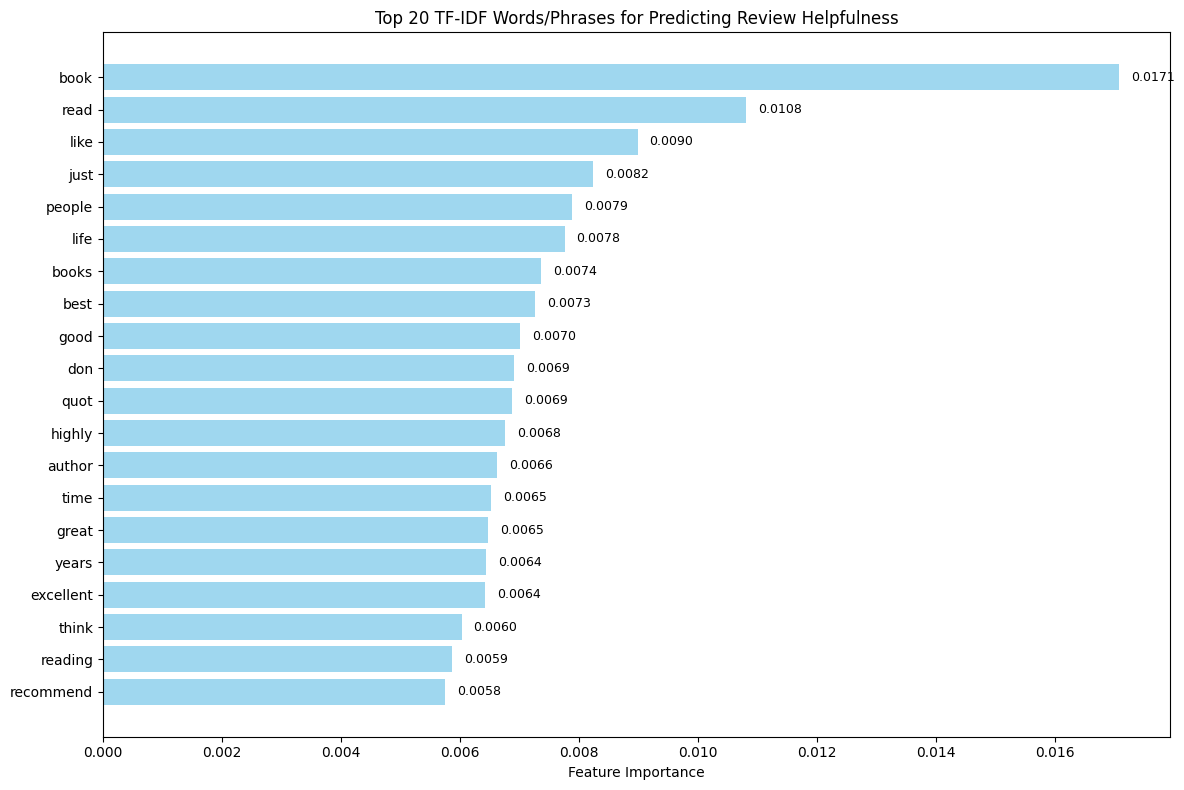

In [11]:
# top TF-IDF features
tfidf_importance = feature_importance[~feature_importance['feature'].isin(engineered_features)]
tfidf_top = tfidf_importance.head(20)

plt.figure(figsize=(12, 8))
plt.barh(range(len(tfidf_top)), tfidf_top['importance'], color='skyblue', alpha=0.8)
plt.yticks(range(len(tfidf_top)), tfidf_top['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 TF-IDF Words/Phrases for Predicting Review Helpfulness')
plt.gca().invert_yaxis()

for i, v in enumerate(tfidf_top['importance']):
    plt.text(v + 0.0002, i, f'{v:.4f}', va='center', fontsize=9)
    
plt.tight_layout()
plt.show()